# Song lyrics exploration - Part 2: Word clouds

# Word cloud

Word clouds are a fun and oftentimes helpful technique for visualizing natural language data. They can show words scaled by any metric, although term frequency and term-frequency inverse-document-frequency (TF-IDF) are the most common metrics. For a multi-class or multi-label classification problem, word clouds can highlight the similarities and differences between separate classes by treating each class as its own document to compare with all others. The word clouds seen here were made with the `WordCloud` generator by [amueller](https://github.com/amueller/word_cloud), with pre-processing done via `gensim` and `nltk`.

In the case of heavy metal genre classification, term frequency alone is not too illuminating: the five genres we analyze here share a lot of common themes since they are all still metal. TF-IDF does much better at picking out the words that are unique to a genre. We see much of what we'd expect from a cursory understanding of each genre: black metal lyrics deal with topics like the occult, religion, and nature; death metal obsesses over the obscene and horrifying; heavy metal revolves around themes more familiar to rock and pop; power metal adopts the vocabulary of fantasies and histories; and thrash metal sings of violence, war, and... beer?

### Imports

In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import words as nltk_words
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
import wordcloud

### Data

In [2]:
df = pd.read_csv('songs-ml-1pct.csv')
genres = df.columns[1:]

### Remove non-English songs

In [3]:
english_words = set(nltk_words.words())

def pct_english(x):
    return len(set(x).intersection(english_words)) / len(set(x))

num_english_words = df.lyrics.str.split().apply(pct_english)
df = df[num_english_words > 0.5]

### Combine songs from same genre into documents

In [4]:
def process_lyrics(s):
    words = [word.lower().strip('.,!?') for word in s.split()]
    words = [word for word in words if word in english_words]
    out = ' '.join(words)
    return out

In [5]:
raw_corpus = [' '.join(df[df[genre] == 1].lyrics.apply(process_lyrics)) for genre in genres]
# raw_corpus = [' '.join(df[(df[genre] == 1) & (df_ml[top_genres].sum(axis=1) == 1)].lyrics.apply(process_lyrics)) for genre in genres]

In [6]:
print("genre word counts:")
for i, genre in enumerate(genres):
    print(f"{genre:<15}{len(raw_corpus[i].split())}")

genre word counts:
black          1117206
death          2448174
deathcore      135125
doom           550665
folk           259706
gothic         373943
grindcore      216795
heavy          1423291
metalcore      281770
power          1898730
progressive    897979
symphonic      468648
thrash         1394295


In [7]:
print("genre vocabulary sizes:")
for i, genre in enumerate(genres):
    print(f"{genre:<15}{len(set(raw_corpus[i].split()))}")

genre vocabulary sizes:
black          17313
death          22800
deathcore      7397
doom           12201
folk           9496
gothic         10222
grindcore      11546
heavy          13742
metalcore      8082
power          14470
progressive    14449
symphonic      11478
thrash         16597


### Stop words

In [8]:
stopwords_dir = 'C:Users/philippe/AppData/Roaming/nltk_data/corpora/stopwords/'
# stopwords_dir = '/home/philippe/nltk_data/corpora/stopwords'
files = os.listdir(stopwords_dir)
languages = [file for file in files if file != 'README']
stopwords = set()
for language in languages:
    stopwords.update(set(nltk_stopwords.words(language)))

### Word cloud

In [9]:
def get_common_surface_form(corpus, stemmer):
    # Create a dictionary for recovering surface forms of words
    from collections import defaultdict
    counts = defaultdict(lambda : defaultdict(int))
    surface_forms = {}
    for document in corpus:
        for token in document:
            stemmed = stemmer.stem(token)
            counts[stemmed][token] += 1
    for stemmed, originals in counts.items():
        surface_forms[stemmed] = max(originals, key=lambda i: originals[i])
    return surface_forms

def process_corpus(corpus, stemmer):
    stemmed_corpus = []
    original_corpus = []
    for document in corpus:
        tokens = word_tokenize(document)
        stemmed = [stemmer.stem(token) for token in tokens]
        stemmed_corpus.append(stemmed)
        original_corpus.append(tokens)
    return stemmed_corpus, original_corpus
    

def get_wordcloud_frequencies(corpus, stemmer, min_df=100):
    print("stemming corpus")
    stemmed_corpus, original_corpus = process_corpus(corpus, stemmer)
    print("creating dictionary")
    dictionary = Dictionary(stemmed_corpus)
    print("generating bag-of-words representation")
    vectors = [dictionary.doc2bow(text) for text in stemmed_corpus]
    if min_df > 0:
        print("filtering words")
        vectors = [[(id_, count) for id_, count in vector if count > min_df] for vector in vectors]
    print("generating TF-IDF model")
    tfidf = TfidfModel(vectors)#, wglobal=lambda x1, x2: np.log2((1 + x2) / (1 + x1)))
    print("recovering surface forms")
    surface_forms = get_common_surface_form(original_corpus, stemmer)
    print("generating frequency dictionaries for WordCloud")
    out = []
    for i in range(len(corpus)):
        top_words = sorted(tfidf[vectors[i]], key=lambda x: x[1])[::-1]
        out.append({surface_forms[dictionary[word]]: score for word, score in top_words})
    return out

stemming corpus
creating dictionary
generating bag-of-words representation
filtering words
generating TF-IDF model
recovering surface forms
generating frequency dictionaries for WordCloud
black


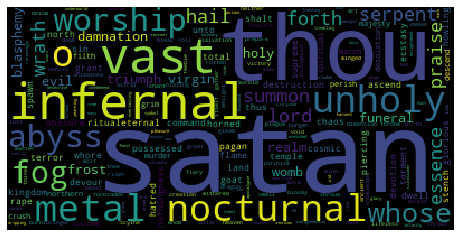

death


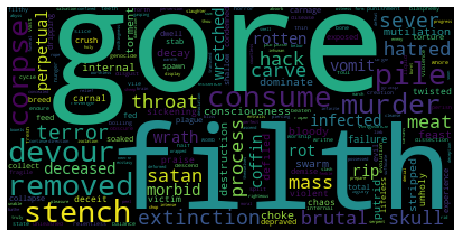

deathcore


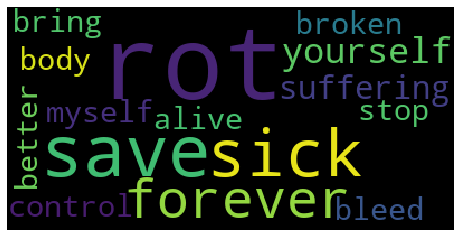

doom


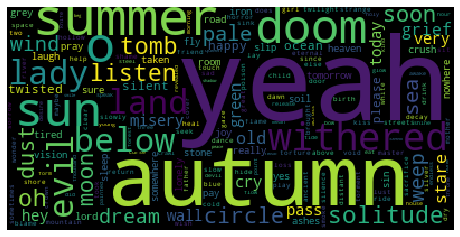

folk


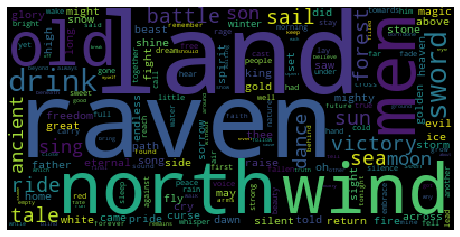

gothic


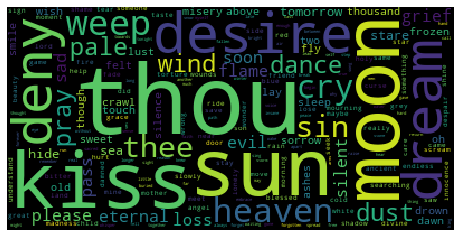

grindcore


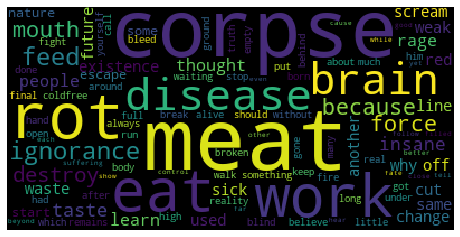

heavy


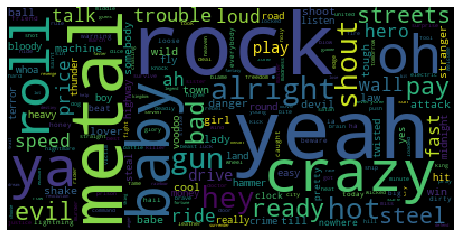

metalcore


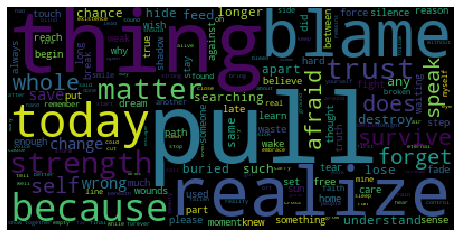

power


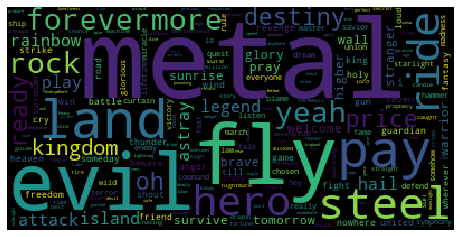

progressive


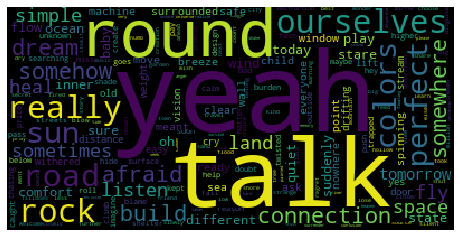

symphonic


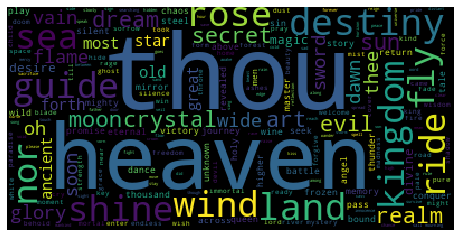

thrash


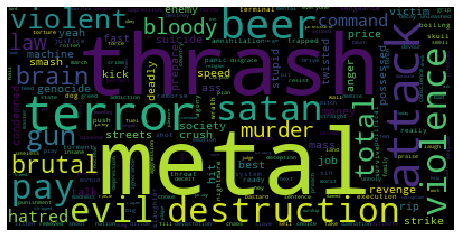

In [10]:
wordcloud_dicts = get_wordcloud_frequencies(raw_corpus, PorterStemmer())
for i, genre in enumerate(genres):
    print(genre)    
    wc = wordcloud.WordCloud(stopwords=stopwords).generate_from_frequencies(wordcloud_dicts[i])
    plt.figure(figsize=(8, 5))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()